In [1]:
from typing import Dict, Tuple
import pandas as pd
import csv
import json
import os
import sys
from pylab import *


sys.path.append("../")
import numpy as np
from serial_broker.Conversion import (
    voltage2force,
    VoltageToForceParameters,
    ParameterManager,
    AmplifierManager,
)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from scipy import signal
import seaborn as sns

In [2]:
def get_section_info() -> Dict[str, str]:
    res = {}
    try:
        with open("../manifests/section.csv", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                block = str(row["block"])
                start_x = int(row["start_x"])
                start_y = int(row["start_y"])
                end_x = int(row["end_x"])
                end_y = int(row["end_y"])
                res[block] = (start_x, end_x, start_y, end_y)
        return res
    except Exception as e:
        print("error reading from csv file")
        raise e

def parse_file(path):
    res = []
    try:
        with open(path, "r") as f:
            while True:
                jline = f.readline()
                if not jline:
                    break
                res.append(json.loads(jline))
        return res
    except Exception as e:
        print("error reading from jsonl file")
        raise e


def custom_mapping_fn(x: np.ndarray):
    x[6][37] = x[6][38]
    return np.array(x)


In [3]:
section_info = get_section_info()
SURFACE = 1.9625e-5
ARRAY_SIZE = (24, 48)
# Init Calibration
M = ParameterManager()
M.read_from_csv("../manifests/calibration.csv")
C = M.params

# Init Amplifier
amp = AmplifierManager()
amp.read_from_csv("../manifests/amplifier.csv")
K = amp.get()

In [4]:
def split_raw_data(raw_data, section_info: Dict[str, Tuple[int, int, int, int]]):
    splited = {
        k: np.empty(shape=(len(raw_data), v[1] - v[0], v[3] - v[2]))
        for k, v in section_info.items()
    }
    timestamp = np.empty(len(raw_data))
    index = np.empty(len(raw_data), dtype=np.int64)
    total = np.empty(shape=(len(raw_data), *ARRAY_SIZE))
    for idx, dp in enumerate(raw_data):
        timestamp[idx] = dp["ts"]
        index[idx] = dp["index"]

        dp_data = np.array(dp["data"])
        dp_data = custom_mapping_fn(dp_data) * K
        dp_force = voltage2force(dp_data, params=C)
        dp_pressure = 0.001*dp_force / SURFACE #单位：kPa
        #dp_pressure = 0.001*dp_force / (SURFACE*150) #单位：kPa  #把150kPa视为最大值做归一化！！！

        for k in section_info.keys():
            start_x, end_x, start_y, end_y = section_info[k]
            try:
                splited[k][idx] = dp_pressure[start_x:end_x, start_y:end_y]
            except Exception as e:
                print(k)
                raise e
        total[idx] = dp_pressure
    return total, splited, timestamp, index

In [5]:
raw_data = parse_file("../log/20230724/Pressing a towel/20230724162603.jsonl") #20230724按
total_pressure, splited_pressure, timestamp, index = split_raw_data(
    raw_data, section_info
)

f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: divide by zero encountered in divide
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)
f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: invalid value encountered in log
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)
f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: invalid value encountered in power
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)


In [6]:
####输出某个时刻点、某个block的压力值#####
timestamp_corrected = timestamp - timestamp[0]
indices = np.where(timestamp_corrected > 78.2 * 1e9)[0][0:1]  #取满足条件的第一个值
data = splited_pressure['2-1'][indices].mean(axis=(1, 2))
print(data)

[]


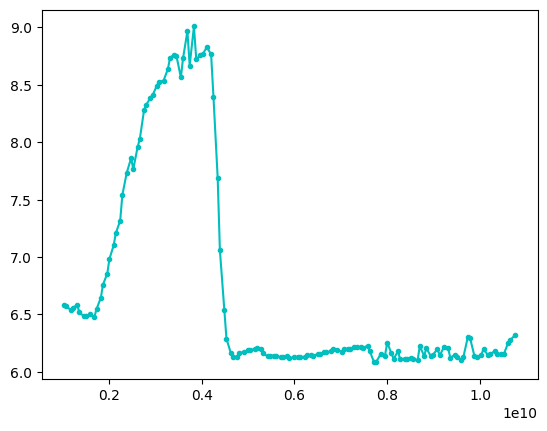

In [7]:
#限定时间在1-100秒的某个block的压力值（注：原始时间单位为ns）
indices = np.where( (100 * 1e9 > timestamp_corrected) &  (timestamp_corrected > 1 * 1e9) ) # select indices and save
plt.plot(timestamp_corrected[indices], splited_pressure["0-33"][indices].mean(axis=(1, 2)), marker="o", linestyle='-', color='c', markersize=3)

In [10]:
####计算参与包饺子的block的压力并保存

#所有手掌上的24个block
BlockList = ['0-11', '0-21', '0-31', '0-41', 
             '0-12', '0-22', '0-32', '0-42', 
             '0-13', '0-23', '0-33', '0-43',
             '0-14', '0-24', '0-34', '0-44',
             '0-15', '0-25', '0-35', '0-45',
             '0-16', '0-26', '0-36', '0-46'
             ]
#采样的时间点（根据已有揉的波形得到，共12个时间点）
#包饺子-揉的时间范围：取12个时间点
#SampleTime = np.array([2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2])   
SampleTime = np.array([2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5])  
#SampleTime = np.array([16,16.1,16.2,16.3,16.4,16.5,16.6,16.7,16.8,16.9,17,17.1]) 
#SampleTime = np.array([29.5,29.6,29.7,29.8,29.9,30,30.1,30.2,30.3,30.4,30.5,30.6])

folder_path = './20230922 analysis/手掌-按/'
file_name1 = 'Total_pressure_array(An2).csv'
file_path1 = folder_path + file_name1


#求所有手掌上blocks的压力
Pressure_palm_arr = np.zeros((24, 12))
for i in range(24):
    for j in range(12):
        indices = np.where(timestamp_corrected > SampleTime[j] * 1e9)[0][0:1]  #取满足条件的第一个值
        Pressure_palm_arr[i][j] = splited_pressure[BlockList[i]][indices].mean(axis=(1, 2))

#print(Total_pressure_array.shape)
# 创建DataFrame对象
df = pd.DataFrame(Pressure_palm_arr.T)  #为了后续计算相关性，把一列存放一个block的数据，故转置
# 保存到csv文件
df.to_csv(file_path1, index=True)



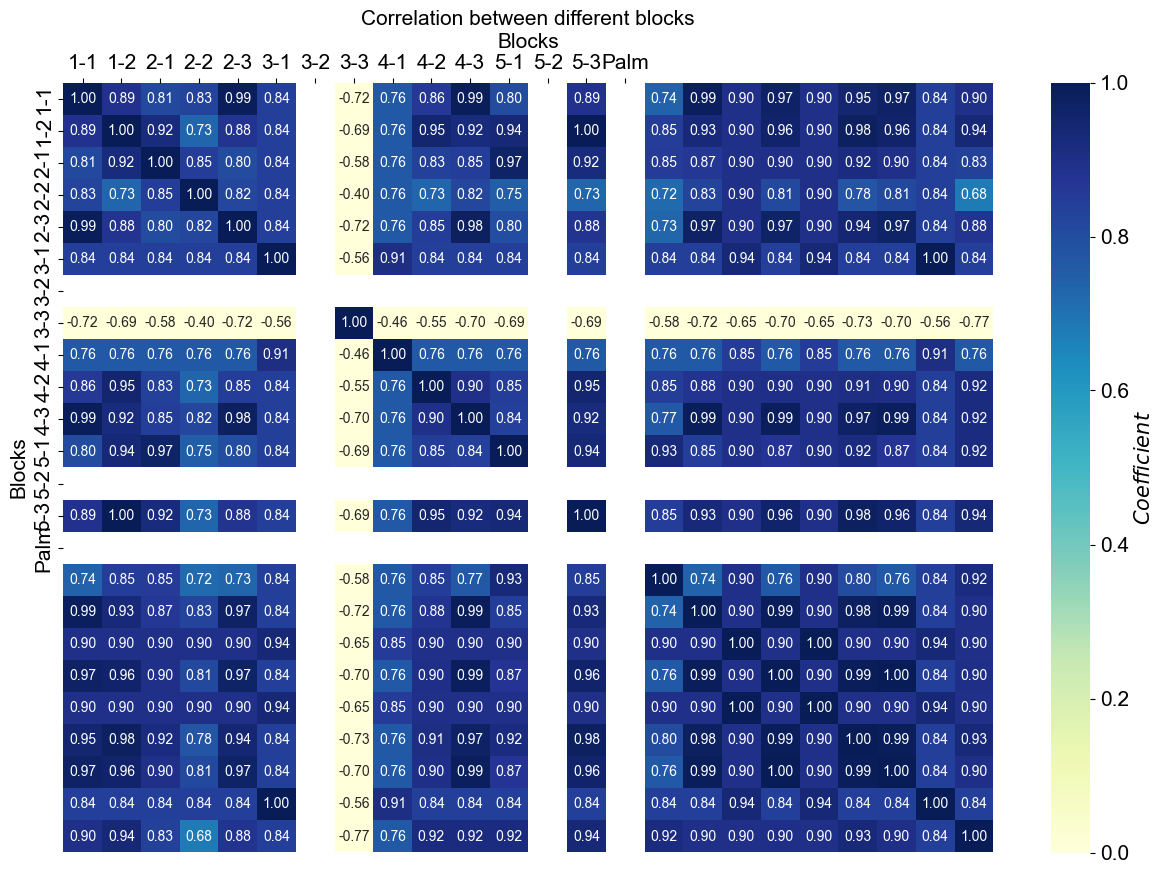

In [11]:
###计算Spearman斯皮尔曼相关性
corr = df.corr(method='spearman')
#print(corr)
folder_path = './20230922 analysis/手掌-按/'
file_name2 = 'Correlation Coefficient(An2).csv'
file_path2 = folder_path + file_name2

corr.to_csv(file_path2, index=True)

# 绘制相关系数热力图
plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr, vmin=0, vmax=1, cmap="YlGnBu", annot=True, fmt='.2f', xticklabels=['1-1', '1-2', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3', '4-1', '4-2', '4-3', '5-1', '5-2', '5-3', 'Palm'], yticklabels=['1-1', '1-2', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3', '4-1', '4-2', '4-3', '5-1', '5-2', '5-3', 'Palm'])

# 设置格式
mpl.rcParams['font.family'] = 'Arial'  #全局字体

font = {'family': 'Arial',
        'color': 'k',
        'weight': 'normal',
        'size': 15}

ax.tick_params(left=True, right=False, top=True, bottom=False, labelleft=True, labelright=False, labeltop=True, labelbottom=False)  #设置轴线位置
plt.xlabel('Blocks',fontsize=15, color='k') 
plt.ylabel('Blocks',fontsize=15, color='k') 
ax.xaxis.set_label_position('top')
plt.xticks(fontsize=15) #x轴刻度的字体大小（文本包含在pd_data中了）
plt.yticks(fontsize=15) 
plt.title('Correlation between different blocks',fontsize=15) #图片标题文本和字体大小
#设置colorbar的刻度字体大小
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
#设置colorbar的label文本和字体大小
cbar = ax.collections[0].colorbar
cbar.set_label(r'$Coefficient$',fontdict=font)

# 保存热力图
folder_path = './20230922 analysis/手掌-按/'
file_name3 = 'heatmap(An2).png'
file_path3 = folder_path + file_name3
plt.savefig(file_path3, dpi=600, bbox_inches='tight')

# 显示图形
plt.show()
